This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case.

In [1]:
%%capture
!pip install git+https://github.com/corentinravoux/flip

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flip import fitter, plot_utils, data_vector
from flip.covariance import covariance, contraction
from pkg_resources import resource_filename
flip_base = resource_filename("flip", ".")
data_path = os.path.join(flip_base, "data")
plt.style.use(os.path.join(data_path,"style.mplstyle"))

[ 000000.00 ]: 09-13 10:08  root            INFO     No pypower module detected, gridding with this method is unavailable
[ 000000.08 ]: 09-13 10:08  jax._src.xla_bridge INFO     Unable to initialize backend 'cuda': 
[ 000000.08 ]: 09-13 10:08  jax._src.xla_bridge INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[ 000000.09 ]: 09-13 10:08  jax._src.xla_bridge INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
[ 000000.09 ]: 09-13 10:08  jax._src.xla_bridge WARNING  An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/tmp/ipykernel_527609/2799973512.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


In [3]:
grid = pd.read_parquet(os.path.join(data_path,"density_data.parquet"))
grid_window = pd.read_parquet(os.path.join(data_path,"grid_window_m.parquet"))

coordinates_density = np.array([grid["ra"], grid["dec"], grid["rcom"]])
data_density = {'density': np.array(grid["density"]), 
                'density_error': np.array(grid["density_err"])}

DataDensity = data_vector.Density(grid.rename(columns={'density_err': 'density_error', 'rcom': 'rcom_zobs'}).to_dict(orient='list'))

ktt, ptt = np.loadtxt(os.path.join(data_path,"power_spectrum_tt.txt"))
kmt, pmt = np.loadtxt(os.path.join(data_path,"power_spectrum_mt.txt"))
kmm, pmm = np.loadtxt(os.path.join(data_path,"power_spectrum_mm.txt"))

sigmag_fiducial = 3.0

power_spectrum_dict_bias = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2]]}
power_spectrum_dict = {"gg": [[kmm, pmm * np.array(grid_window["window_mm"])**2],
                              [kmt, pmt * np.array(grid_window["window_mt"])],
                              [ktt, ptt]]}


# Fit beta_f 

In [4]:
size_batch=10_000
number_worker=8
covariance_fit = DataDensity.compute_cov("adamsblake20", power_spectrum_dict, size_batch=size_batch, 
                                          number_worker=number_worker, additional_parameters_values=(sigmag_fiducial,))

covariance_fit = covariance.CovMatrix.init_from_flip(
    "adamsblake20",
    "density",
    power_spectrum_dict,
    coordinates_density=coordinates_density,
    size_batch=size_batch,
    number_worker=number_worker,
    additional_parameters_values=(sigmag_fiducial,),
)

/pscratch/sd/b/bastienc/Soft/.miniconda3/envs/flip/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[ 000001.19 ]: 09-13 10:08  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 9.35e-01 seconds
[ 000002.10 ]: 09-13 10:08  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 9.01e-01 seconds


In [5]:
likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "inverse"}

parameter_dict = {"bs8": {"value": 1.0,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "beta_f": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }




minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DataDensity,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties)
print('Free parameters are:', minuit_fitter.likelihood.free_par)

minuit_fitter.run()


Free parameters are: ['bs8', 'beta_f']


[ 000022.38 ]: 09-13 10:08  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1523                       │              Nfcn = 50               │
│ EDM = 2.06e-09 (Goal: 0.0002)    │           time = 20.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬─────────

{'bs8': 0.8231078032741832, 'beta_f': 0.3081756369265884}

# Fit beta_f with an interpolation scheme for sigma_g

In [6]:
sigmag_list = np.linspace(0.5, 3.0, 10)
covariance_list = []


for sigg in sigmag_list:
    covariance_list.append(covariance.CovMatrix.init_from_flip(
        "adamsblake20",
        "density",
        power_spectrum_dict,
        coordinates_density=coordinates_density,
        size_batch=size_batch,
        number_worker=number_worker,
        additional_parameters_values=(sigg,),
)
)


/pscratch/sd/b/bastienc/Soft/.miniconda3/envs/flip/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[ 000023.29 ]: 09-13 10:08  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 8.93e-01 seconds
[ 000024.20 ]: 09-13 10:08  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 9.07e-01 seconds
[ 000025.13 ]: 09-13 10:08  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 9.30e-01 seconds
[ 000026.07 ]: 09-13 10:08  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 9.39e-01 seconds
[ 000027.23 ]: 09-13 10:08  root            INFO     Covariance matrix generated from flip with adamsblake20 model in 1.16e+00 seconds
[ 000028.24 ]: 09-13 10:08  root            INF

In [7]:
parameter_dict = {"bs8": {"value": 1.0,
                          "fixed" : False,
                          "limit_low" : 0.0,
                         },
                  "beta_f": {"value": 0.1,
                          "fixed" : False,
                          "limit_low" : 0.0,
                         },
                  "sigg": {"value": 2.0,
                          "limit_low" : 0.5,
                          "limit_up" : 3.0,
                          "fixed" : False,
                         },
                 }    



likelihood_type="multivariate_gaussian_interp1d"
likelihood_properties = {"inversion_method": "inverse"}



minuit_fitter_interp = fitter.FitMinuit.init_from_covariance(
        covariance_list,
        DataDensity,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
        interpolation_value_name = "sigg",
        interpolation_value_range = sigmag_list,
)

print('Free parameters are:', minuit_fitter_interp.likelihood.free_par)

minuit_fitter_interp.run()


Free parameters are: ['bs8', 'beta_f', 'sigg']


[ 000087.84 ]: 09-13 10:09  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1523                       │              Nfcn = 105              │
│ EDM = 1.02e-06 (Goal: 0.0002)    │           time = 53.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬─────────

{'bs8': 0.8285688914519499,
 'beta_f': 0.21116849929615397,
 'sigg': 1.5986078727191197}

# Some plots

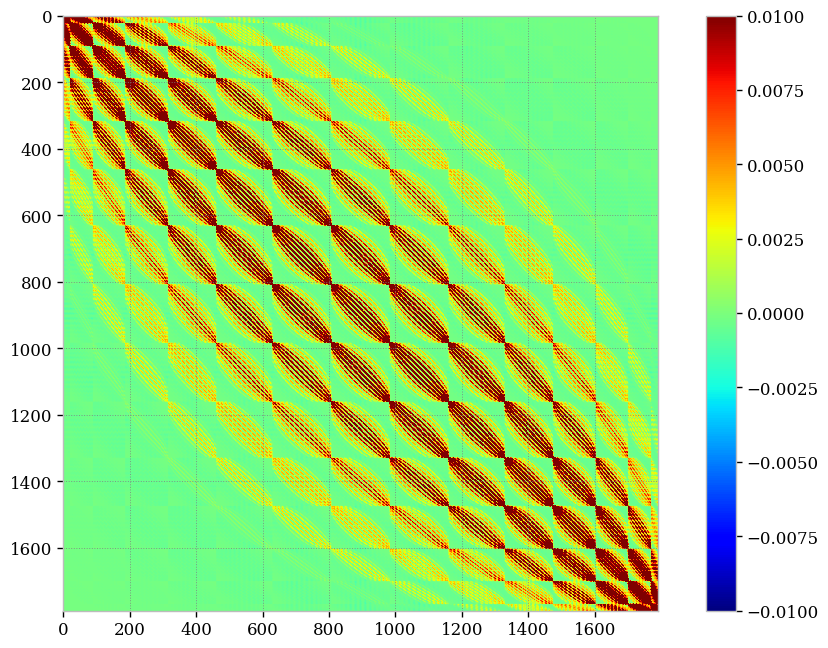

In [8]:
plot_utils.plot_correlation_from_likelihood(
    minuit_fitter.likelihood,
    parameter_dict, 
    vmin = -0.01, vmax= 0.01
)

/pscratch/sd/b/bastienc/Soft/.miniconda3/envs/flip/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


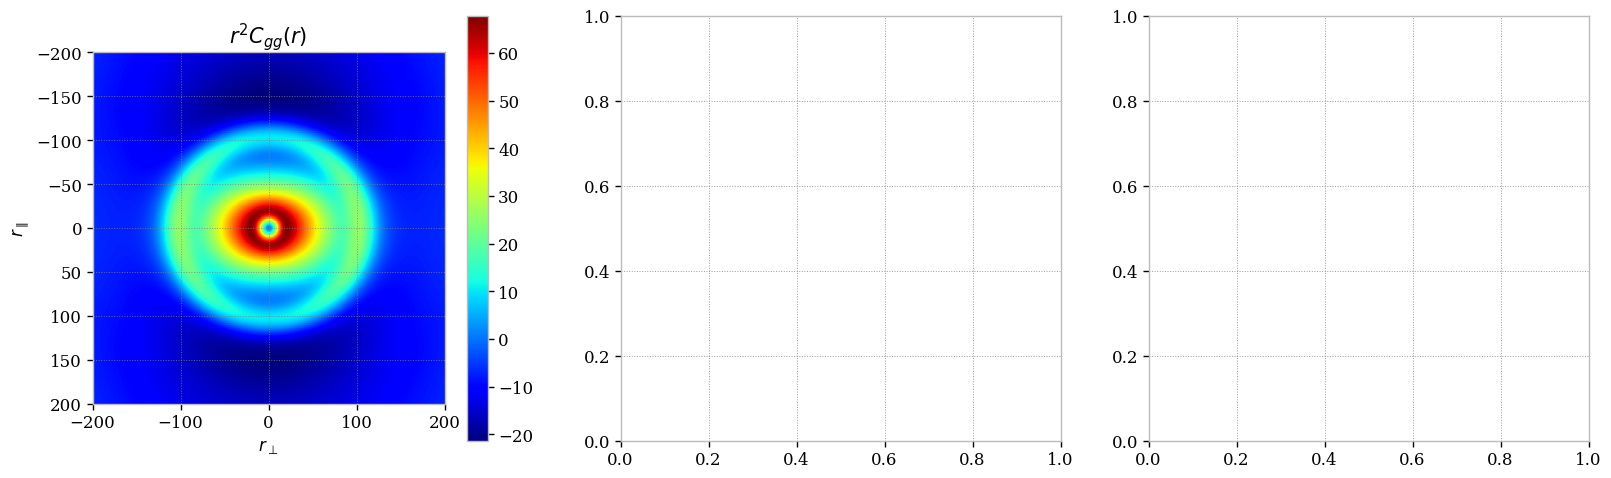

In [9]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "adamsblake20",
    "density",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
    additional_parameters_values=(sigmag_fiducial,),
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}


plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)
